In [1]:
from fastai import *
from fastai.vision.all import *
from models import conv, deconv

import sys
sys.path.append('..')
from src.band_plotters import *
from src.Tiff32Image import TiffImage, TiffImageNoised, AddNoiseTransform, RandomErasingTransform

In [12]:
PADDED = False
SELECTED_HEIGHT = 128
SELECTED_WIDTH = 128
THRESHOLD = 4

MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI =  7
MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI =  -7

# from save_autoencoder_images:
MAX_ENERGY_MINUS_EFERMI =  20 # actually 30 but only 1 material exceeds 20
MIN_ENERGY_MINUS_EFERMI =  -17 # actually -100 but only 2 materials exceed -22 

In [13]:
if PADDED:
    resize_func = CropPad((SELECTED_HEIGHT, SELECTED_WIDTH))
else:
    resize_func = Resize((SELECTED_HEIGHT, SELECTED_WIDTH))

## Load

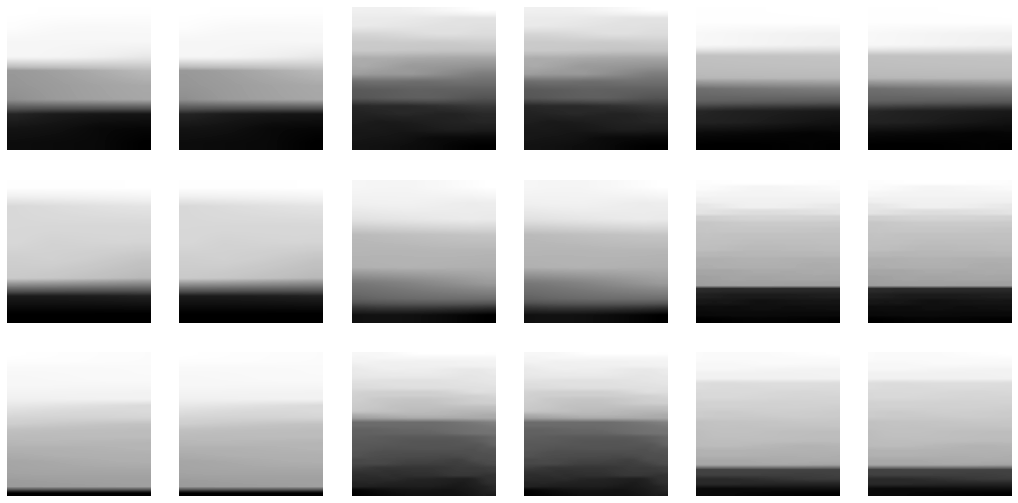

In [14]:
dls = DataBlock(
    blocks=(ImageBlock(cls=TiffImage), ImageBlock(cls=TiffImageNoised)), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1),
    item_tfms=[resize_func],# AddNoiseTransform(std=1)], #RandomErasingTransform()], #AddNoiseTransform(std=1)],
    batch_tfms=[IntToFloatTensor(div=2**16-1), resize_func],
        ).dataloaders(DATA_DIRECTORY/f"images/energies{THRESHOLD}", bs=64)

dls.show_batch()

In [15]:
xb, yb = dls.one_batch()
yb.min()

TensorImageNoised(0.1155, device='cuda:0')

(TensorImageBW(0.2041, device='cuda:0'),
 TensorImageBW(0.7844, device='cuda:0'))

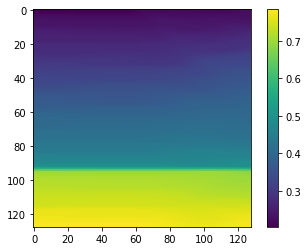

In [16]:
i=4
plt.imshow(xb[i][0].cpu()) 
plt.colorbar()
xb[i].min(), xb[i].max()

## Train

### Create Learner

epoch,train_loss,valid_loss,time
0,0.021780,0.021762,00:12
1,0.010613,0.056731,00:09
2,0.004910,0.008867,00:09
3,0.002972,0.011656,00:09
4,0.001862,0.004492,00:09
5,0.001354,0.015160,00:09
6,0.001135,0.003320,00:10
7,0.000876,0.004220,00:10
8,0.000802,0.009758,00:11
9,0.000691,0.003310,00:10


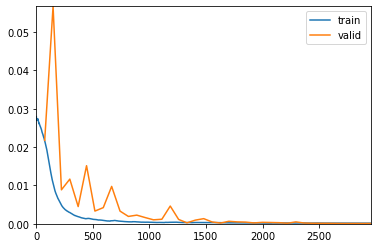

epoch,train_loss,valid_loss,time
0,0.022604,0.020930,00:09
1,0.010019,0.027035,00:09
2,0.004607,0.009669,00:09
3,0.002804,0.005574,00:09
4,0.001910,0.005924,00:07
5,0.001487,0.003988,00:09
6,0.001170,0.002768,00:09
7,0.000894,0.003655,00:09
8,0.000682,0.003632,00:09
9,0.000664,0.001246,00:09


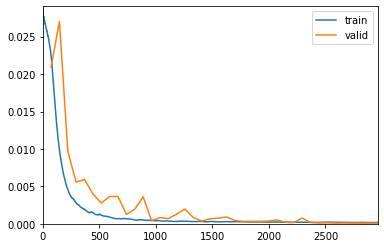

epoch,train_loss,valid_loss,time
0,0.025785,0.026385,00:09
1,0.014869,0.068059,00:09
2,0.006435,0.012271,00:08
3,0.003862,0.007278,00:09
4,0.002303,0.011990,00:09
5,0.001737,0.005195,00:09
6,0.001259,0.010764,00:09
7,0.000978,0.002880,00:09
8,0.000751,0.001781,00:09
9,0.000652,0.002073,00:09


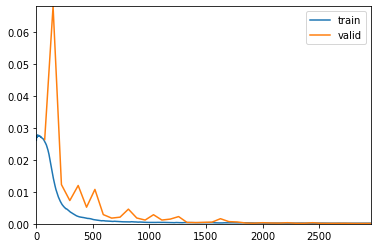

epoch,train_loss,valid_loss,time
0,0.025166,0.025442,00:09
1,0.016948,0.075289,00:09
2,0.007712,0.006518,00:08
3,0.004403,0.004786,00:07
4,0.002730,0.010536,00:09
5,0.001795,0.002273,00:08
6,0.001392,0.002124,00:09
7,0.001031,0.006488,00:10
8,0.000819,0.003399,00:09
9,0.000797,0.006388,00:09


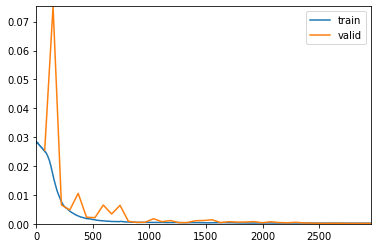

epoch,train_loss,valid_loss,time
0,0.026132,0.026543,00:10
1,0.016566,0.038381,00:09
2,0.008148,0.010595,00:07
3,0.004905,0.007106,00:07
4,0.003237,0.006142,00:08
5,0.001967,0.005420,00:09
6,0.001311,0.005797,00:09
7,0.000898,0.001330,00:08
8,0.000773,0.002604,00:08
9,0.000655,0.000536,00:09


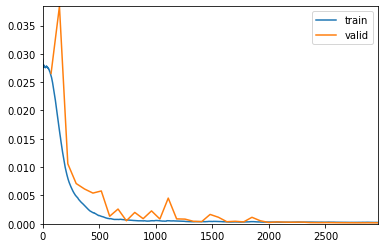

epoch,train_loss,valid_loss,time
0,0.025313,0.025658,00:11
1,0.019504,0.019317,00:10
2,0.011049,0.014646,00:10
3,0.006554,0.005072,00:10
4,0.004227,0.006484,00:09
5,0.002927,0.010835,00:09
6,0.002304,0.005805,00:09
7,0.001670,0.001627,00:11
8,0.001452,0.003937,00:09
9,0.001060,0.001556,00:08


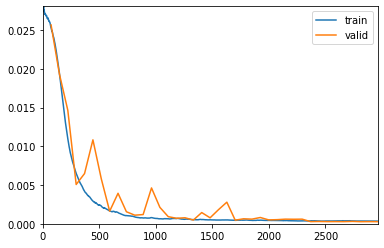

epoch,train_loss,valid_loss,time
0,0.024934,0.026389,00:09
1,0.019967,0.016730,00:09
2,0.012338,0.010862,00:08
3,0.007535,0.006243,00:09
4,0.005473,0.004801,00:07
5,0.003479,0.002708,00:09
6,0.002305,0.003985,00:09
7,0.001695,0.002715,00:09
8,0.001375,0.001253,00:09
9,0.001218,0.005508,00:08


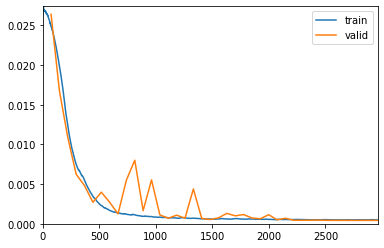

epoch,train_loss,valid_loss,time
0,0.026019,0.027271,00:09
1,0.023266,0.021655,00:09
2,0.017563,0.013581,00:08
3,0.010189,0.010452,00:09
4,0.006875,0.016816,00:09
5,0.004912,0.006804,00:09
6,0.003526,0.008196,00:09
7,0.002666,0.029430,00:09
8,0.002029,0.008361,00:09
9,0.001827,0.002772,00:09


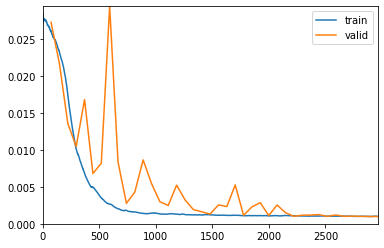

In [17]:

from models import SimpleAutoencoder128, SimpleAutoencoderDeep128
n_latents = [256, 128, 64, 32, 16, 8, 4, 2]

for n in n_latents:
    ae = SimpleAutoencoderDeep128(n_latent=n)
    learn = Learner(dls, ae, F.mse_loss, cbs=[ShowGraphCallback()])
    learn.fit_one_cycle(40)
    learn.export(f"trained_models/nearest_12_v1_length_{n}_padded_{PADDED}.pkl")

## View Predictions

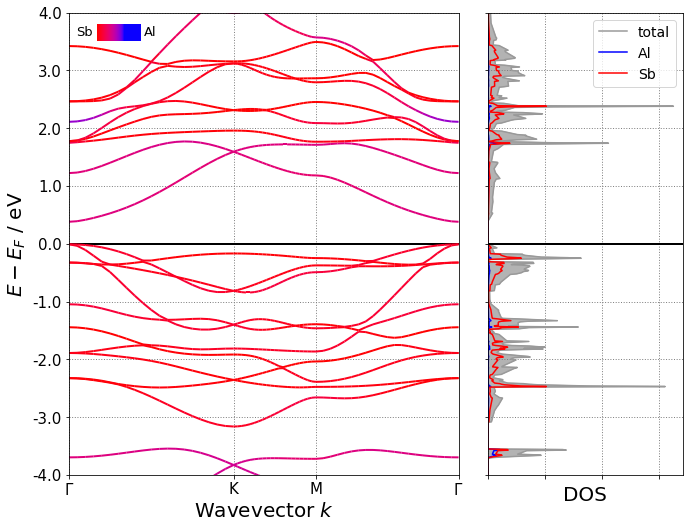

In [18]:
plot("2dm-26")

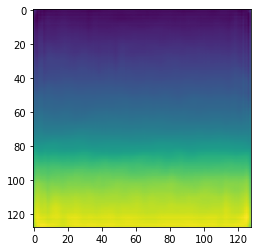

<AxesSubplot:>

In [19]:
image = TiffImage.create(DATA_DIRECTORY/"images/energies4/2dm-21.tiff")
out = learn.predict(image)

plt.imshow(out[2].numpy()[0])
plt.show()
image.show()

array([<AxesSubplot:title={'center':'Input'}>,
       <AxesSubplot:title={'center':'Reconstruction'}>], dtype=object)

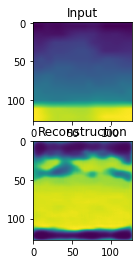

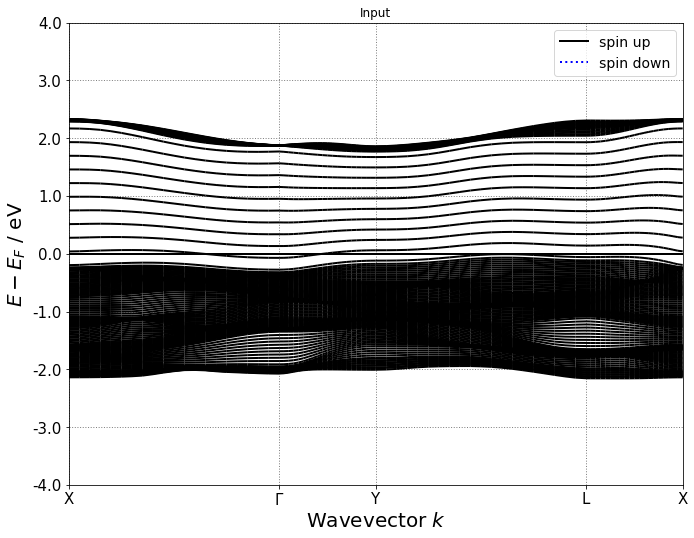

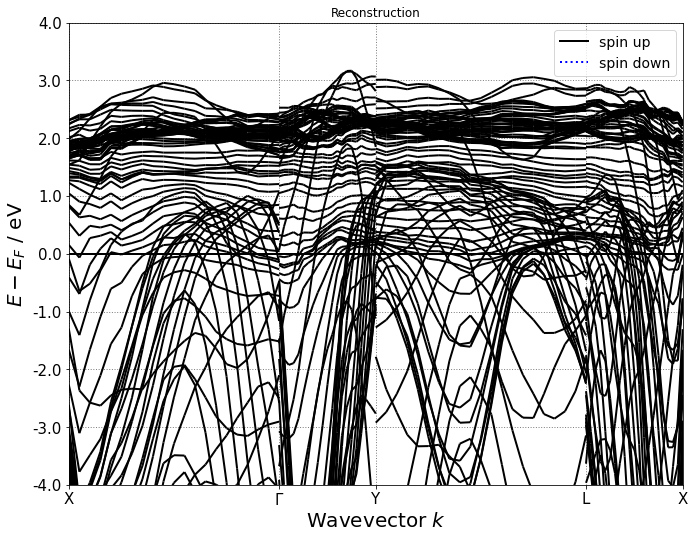

In [10]:
view_prediction("2dm-29", learn.model, MIN_ENERGY_MINUS_EFERMI, MAX_ENERGY_MINUS_EFERMI, width=SELECTED_WIDTH, height=SELECTED_HEIGHT, height_mode="squish")